Federated Learning Based LLM Fine-Tuning of LLAMA 3.2-1bn 

In [ ]:
#%pip install flwr==1.18.0
#%pip install flwr_datasets==0.5.0
#%pip install hydra-core==1.3.2
#%pip install -U "flwr[simulation]"

In [1]:
import sys
# Ensure we aren't accidentally pulling from Roaming
sys.path = [p for p in sys.path if "Roaming" not in p]

try:
    from scipy import sparse
    import sklearn
    print("Success! Scipy Sparse and Sklearn are both loaded.")
except ImportError as e:
    print(f"Still failing: {e}")

Success! Scipy Sparse and Sklearn are both loaded.


In [2]:
#import unsloth
import json
from datasets import Dataset
import sys
#from unsloth import FastLanguageModel
from trl import SFTTrainer, SFTConfig #DataCollatorForCompletionOnlyLM
import torch

import os
from dotenv import load_dotenv
load_dotenv()


c:\Users\Public\anaconda3\envs\agenticEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0222 12:32:19.489000 12652 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


True

In [3]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
#from langchain_community.chains import LLMChain
import json
from langchain_community.llms import Ollama
from langchain_community.chat_models import ChatOllama
import os
import urllib.request
from pathlib import Path
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
import pandas as pd
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings, OpenAIEmbeddings
#from langchain.evaluation import load_evaluator
from datasets import Dataset
from ragas.metrics.collections import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
)
from ragas.llms import LangchainLLMWrapper
from datasets import load_dataset
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import Faithfulness, AnswerRelevancy, AnswerCorrectness, ContextUtilization, ContextPrecision
from openai import OpenAI
from ragas.llms import llm_factory
from ragas.embeddings import embedding_factory
from ragas.metrics.base import Metric
from langchain_experimental.text_splitter import SemanticChunker

import random
from typing import List
from pydantic import BaseModel
from langchain_core.output_parsers import PydanticOutputParser, JsonOutputParser
from prompts import ORACLE_GEN_PROMPT, RAFT_COT_GEN_PROMPT

from pydantic import BaseModel, Field
from langchain_community.vectorstores import FAISS
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from IPython.display import display, Markdown
from transformers import TrainingArguments

import flwr as fl
from flwr_datasets.partitioner import IidPartitioner
from flwr_datasets import FederatedDataset
import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
)
from peft.utils import prepare_model_for_kbit_training
from flwr.common import Context
from flwr.common.typing import NDArrays, Scalar
from flwr.client import NumPyClient
from flwr.client.mod import fixedclipping_mod
from flwr.server.strategy import (
    DifferentialPrivacyClientSideFixedClipping
)

from typing import Dict, Tuple, Callable
from collections import OrderedDict
import math
from logging import ERROR


load_dotenv()

C:\Users\Namrata Thakur\AppData\Local\Temp\ipykernel_12652\3875395804.py:32: DeprecationWarning: Importing Faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import Faithfulness
  from ragas.metrics import Faithfulness, AnswerRelevancy, AnswerCorrectness, ContextUtilization, ContextPrecision
C:\Users\Namrata Thakur\AppData\Local\Temp\ipykernel_12652\3875395804.py:32: DeprecationWarning: Importing AnswerRelevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import AnswerRelevancy
  from ragas.metrics import Faithfulness, AnswerRelevancy, AnswerCorrectness, ContextUtilization, ContextPrecision
C:\Users\Namrata Thakur\AppData\Local\Temp\ipykernel_12652\3875395804.py:32: DeprecationWarning: Importing AnswerCorrectness from 'ragas.metrics' is deprecated and will be removed 

True

In [4]:
import wandb
wandb.login(relogin=True)

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Create a new API key at: https://wandb.ai/authorize?ref=models
wandb: Store your API key securely and do not share it.
wandb: Paste your API key and hit enter:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Namrata Thakur\_netrc
wandb: Currently logged in as: namrata-thakur5790 (namrata-thakur5790-ibm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cu130
CUDA available: True
CUDA version: 13.0
GPU: NVIDIA GeForce GTX 1650 Ti


In [5]:
import torch
print(f"PyTorch CUDA: {torch.version.cuda}")
print(torch.cuda.get_device_capability())
!nvcc --version

PyTorch CUDA: 13.0
(7, 5)


'nvcc' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
!nvidia-smi

Thu Feb 19 22:57:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.83                 Driver Version: 581.83         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              3W /   50W |      95MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
openai_api_key = os.getenv("OPENAI_API_KEY")

Federated Learning Config Setup:

In [14]:
fl_config = {
    'dataset' : {
        'name': "medalpaca/medical_meadow_medical_flashcards"
        },
    'model' : {
        'name' : "meta-llama/Llama-3.2-1B-Instruct",
        'quantization' : 4,
        'gradient_checkpointing': True,
        'use_fast_tokenizer': True,
        'lora': {
            'peft_lora_r': 16,
            'peft_lora_alpha': 64,
            'target_modules': ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",]
                }
        },
    'train': {
        'num_rounds': '${flower.num_rounds}',
        'save_every_round': 5,
        'learning_rate_max': 5e-05,
        'learning_rate_min': 1e-06,
        'seq_length': 2048,
        'padding_side': 'left',
        'evaluate_split': True,
        'training_arguments': {
            'output_dir': None, # to be set by hydra
            'learning_rate': None, # to be set by the client
            'per_device_train_batch_size': 2,
            'gradient_accumulation_steps': 8,
            'logging_steps': 5,
            'max_steps': 250,
            # 'num_train_epochs': 1,
            'report_to': 'wandb',
            'run_name': "Llama3.2-1bn_FedLearn_v1",
            'save_steps': 1000,
            'save_total_limit': 10,
            'gradient_checkpointing': '${model.gradient_checkpointing}',
            'lr_scheduler_type': 'constant'
            }
        },
    'client_resources' : {
        'num_cpus' : 8,
        'num_gpus' : 1.0
        },
    'dp' : {
        'noise_mult' : 0.02,
        'clip_norm' : 0.5
        },  
    'flower': {
        'num_clients': 20,
        'num_rounds': 200, #Federated Learning will continue for 200 rounds, at each round it will select 0.8% of 20 clients
        'fraction_fit': 0.8,
        'client_resources': {
            'num_cpus': 4,
            'num_gpus': 1.0
        },
        'dp': {
            'noise_mult': 0.02,
            'clip_norm': 0.5
        }
    }
}

config = OmegaConf.create(fl_config)
OmegaConf.save(config=config, f="../config/federatedConfig_llama3.2-1bn.yml")

In [5]:
def get_config(config_name, config_path="../config/"):
    with initialize(config_path=config_path, version_base="1.1"):
        config = compose(config_name=config_name)
    
    return config

def print_config(config_obj):
    print(OmegaConf.to_yaml(config_obj))

In [6]:
fl_config = get_config("federatedConfig_llama3.2-1bn.yml")
print_config(fl_config)

dataset:
  name: medalpaca/medical_meadow_medical_flashcards
model:
  name: meta-llama/Llama-3.2-1B-Instruct
  quantization: 4
  gradient_checkpointing: true
  use_fast_tokenizer: true
  lora:
    peft_lora_r: 16
    peft_lora_alpha: 64
    target_modules:
    - q_proj
    - k_proj
    - v_proj
    - o_proj
    - gate_proj
    - up_proj
    - down_proj
train:
  num_rounds: ${flower.num_rounds}
  save_every_round: 5
  learning_rate_max: 5.0e-05
  learning_rate_min: 1.0e-06
  seq_length: 2048
  padding_side: left
  evaluate_split: true
  training_arguments:
    output_dir: null
    learning_rate: null
    per_device_train_batch_size: 2
    gradient_accumulation_steps: 8
    logging_steps: 5
    max_steps: 250
    report_to: wandb
    run_name: Llama3.2-1bn_FedLearn_v1
    save_steps: 1000
    save_total_limit: 10
    gradient_checkpointing: ${model.gradient_checkpointing}
    lr_scheduler_type: constant
client_resources:
  num_cpus: 8
  num_gpus: 1.0
dp:
  noise_mult: 0.02
  clip_norm: 0

c:\Users\Public\anaconda3\envs\agenticEnv\Lib\site-packages\hydra\plugins\config_source.py:125: UserWarning: Support for .yml files is deprecated. Use .yaml extension for Hydra config files
  deprecation_warning(


Load and partition the datasets for Flower simulations:

In [7]:
#REF: https://learn.deeplearning.ai/courses/intro-to-federated-learning-c2/lesson/bavtp/smarter-llms-with-private-data

def format_dataset(dataset):
    """Helper function to format the dataset"""

    dataset = dataset.remove_columns(['instruction'])
    dataset = dataset.rename_column("output", "response")
    dataset = dataset.rename_column("input", "instruction")
    return dataset

def visualize_partitions(fed_dataset: FederatedDataset):
    """Helper function to visualize the partitions of the dataset"""

   # _ = fed_dataset.load_partition(0)
    num_partitions = fed_dataset.partitioners['train'].num_partitions

    plt.bar(range(num_partitions), [len(fed_dataset.load_partition(i)) for i in range(num_partitions)])
    plt.xticks(range(num_partitions))
    plt.xlabel("Partition ID")
    plt.ylabel("Number of examples")
    plt.title(f"IID partitioning into {num_partitions} partitions")

c:\Users\Public\anaconda3\envs\agenticEnv\Lib\site-packages\flwr_datasets\utils.py:109: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps', 'scikit-learn/iris', 'flwrlabs/pacs', 'flwrlabs/cinic10', 'flwrlabs/caltech101', 'flwrlabs/office-home', 'flwrlabs/fed-isic2019']. Given: medalpaca/medical_meadow_medical_flashcards.
  warnings.warn(


Dataset({
    features: ['instruction', 'response'],
    num_rows: 1698
})


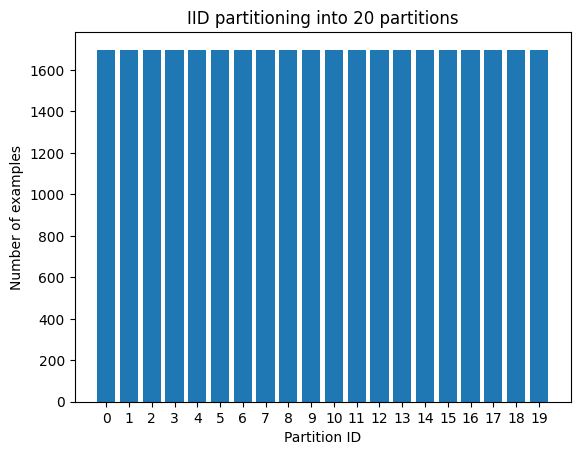

In [8]:
partioners = IidPartitioner(num_partitions=fl_config.flower.num_clients)
fed_datasets = FederatedDataset(dataset=fl_config.dataset.name, partitioners={'train':partioners}, seed=24 )
print(format_dataset(fed_datasets.load_partition(0)))
visualize_partitions(fed_dataset=fed_datasets)

Loading the Model:

In [9]:
def get_model(model_config):

    cuda = torch.cuda.is_available()
    quantization_config = None
    model_name = model_config.model.name
    if cuda:
        #Load the quantization:
        if model_config.model.quantization == 8:
            quantization_config = BitsAndBytesConfig(load_in_8bit=True)
        elif model_config.model.quantization == 4:
            quantization_config = BitsAndBytesConfig(load_in_4bit=True)
        else:
            raise ValueError(f"Quantization needs to be either 8 or 4. Value in model config is {model_config.model.quantization}")
        
        model_name = model_config.model.name

    #Load the base model using Huggingface Transformer library:
    model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quantization_config, dtype = torch.bfloat16, low_cpu_mem_usage=True )

    if cuda:
        model = prepare_model_for_kbit_training(model=model, use_gradient_checkpointing=model_config.model.gradient_checkpointing)

    #Add the Lora adapters:
    target_modules = model_config.model.lora.target_modules
    if target_modules:
        target_modules = list(target_modules)
    
    peft_config = LoraConfig(r=model_config.model.lora.peft_lora_r, lora_alpha=model_config.model.lora.peft_lora_alpha, target_modules=target_modules, lora_dropout=0.075,
                             task_type="CAUSAL_LM")
    peft_model = get_peft_model(model=model, peft_config=peft_config)

    if not(cuda):
        peft_model.enable_input_require_grads()

    if model_config.model.gradient_checkpointing:
        model.config.use_cache = False
    
    #Return the peft version of the model, NOT the full model:
    return peft_model        


In [12]:
def compute_communication_costs(config, comm_bw_mbps: float = 20):
      """
      We use Flower's helper function to compute communication costs of federated finetuning.
      Get ready to see the savings!
      """
      model = get_model(config)

      trainable, all_parameters = model.get_nb_trainable_parameters()

      total_size = 4*all_parameters/(1024**2)
      trainable_size = 4*trainable/(1024**2)

      upload_time_total = total_size/(comm_bw_mbps/8)
      upload_time_finetune = trainable_size/(comm_bw_mbps/8)

      print(f"Full model:\n\t{all_parameters/1e6:.3f} M parameters\n\t{total_size:.2f} MB --> upload in {upload_time_total:.2f}s @ {comm_bw_mbps}Mbps")
      print(f"Finetuned model:\n\t{trainable/1e6:.3f} M parameters\n\t{trainable_size:.2f} MB --> upload in {upload_time_finetune:.2f}s @ {comm_bw_mbps}Mbps")
      # print(f"In a {comm_bw_mbps} Mbps channel --> {}")

      num_rounds = config.flower.num_rounds
      num_clients_per_round = int(config.flower.num_clients * config.flower.fraction_fit)
      print(f"Federated Learning setting: "
            f"\n\tNumber of rounds: {num_rounds}"
            f"\n\tNumber of clients per round: {num_clients_per_round}")

      print(f"-----------------------------------------------")
      print(f"Total Communication costs (Full model): {2*num_rounds*num_clients_per_round*total_size/1024:.1f} GB")
      print(f"Total Communication costs (Finetuning): {2*num_rounds*num_clients_per_round*trainable_size} MB")
      print(f"Communication savings: {all_parameters/trainable:.1f}x")

In [34]:
compute_communication_costs(fl_config, comm_bw_mbps=20)

Full model:
	1247.087 M parameters
	4757.26 MB --> upload in 1902.90s @ 20Mbps
Finetuned model:
	11.272 M parameters
	43.00 MB --> upload in 17.20s @ 20Mbps
Federated Learning setting: 
	Number of rounds: 200
	Number of clients per round: 16
-----------------------------------------------
Total Communication costs (Full model): 29732.9 GB
Total Communication costs (Finetuning): 275200.0 MB
Communication savings: 110.6x


Format the dataset according to Alpaca Prompt:

In [10]:
def formatting_prompts_func(example):
    prompts = []
    response = []
    
    #Building a standard Alpaca Prompt:
    sys_message = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    for i in range(len(example["instruction"])):
        prompt = f"{sys_message}\n### Instruction:\n{example['instruction'][i]}\n### Response:"
        completion = f"  {example['response'][i]}"
        prompts.append(prompt)
        response.append(completion)
        
    return {
            'prompt':prompts,
            'completion':response
            }

In [11]:
def get_tokenizer_and_prompt_format(model_name, use_fast, padding_side):

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=use_fast, padding_side=padding_side)
    tokenizer.pad_token = (tokenizer.bos_token if padding_side == 'left' else tokenizer.eos_token)

    return tokenizer, formatting_prompts_func


In [12]:
tokenizer, formatting_prompts_func = get_tokenizer_and_prompt_format(model_name=fl_config.model.name, use_fast=fl_config.model.use_fast_tokenizer, 
                                                                     padding_side=fl_config.train.padding_side)

Define the Flower Client:

In [13]:
#REF: #REF: https://learn.deeplearning.ai/courses/intro-to-federated-learning-c2/lesson/bavtp/smarter-llms-with-private-data
def cosine_annealing(
    current_round: int,
    total_round: int,
    lrate_max: float = 0.001,
    lrate_min: float = 0.0,
) -> float:
    """Implement cosine annealing learning rate schedule. Strictly speaking this
    is not necessary."""

    cos_inner = math.pi * current_round / total_round
    return lrate_min + 0.5 * (lrate_max - lrate_min) * (1 + math.cos(cos_inner))

In [14]:
fl_config

{'dataset': {'name': 'medalpaca/medical_meadow_medical_flashcards'}, 'model': {'name': 'meta-llama/Llama-3.2-1B-Instruct', 'quantization': 4, 'gradient_checkpointing': True, 'use_fast_tokenizer': True, 'lora': {'peft_lora_r': 16, 'peft_lora_alpha': 64, 'target_modules': ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']}}, 'train': {'num_rounds': '${flower.num_rounds}', 'save_every_round': 5, 'learning_rate_max': 5e-05, 'learning_rate_min': 1e-06, 'seq_length': 2048, 'padding_side': 'left', 'evaluate_split': True, 'training_arguments': {'output_dir': None, 'learning_rate': None, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 8, 'logging_steps': 5, 'max_steps': 250, 'report_to': 'wandb', 'run_name': 'Llama3.2-1bn_FedLearn_v1', 'save_steps': 1000, 'save_total_limit': 10, 'gradient_checkpointing': '${model.gradient_checkpointing}', 'lr_scheduler_type': 'constant'}}, 'client_resources': {'num_cpus': 8, 'num_gpus': 1.0}, 'dp': {'noise_mult': 0.02

In [15]:
#Define the function for setting parameters:
def set_parameters(model, parameters: NDArrays) -> None:
    """Change the parameters of the model using the given ones."""
    model_keys = get_peft_model_state_dict(model).keys()
    state_dict_peft = zip(model_keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k,v in state_dict_peft})
    set_peft_model_state_dict(model=model, peft_model_state_dict=state_dict)

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, model_config:DictConfig,
                       tokenizer, fed_dataset, formatting_prompts_func, save_path ):
        
        self.model_config = model_config
        self.train_config = model_config.train
        self.tokenizer = tokenizer
        self.fed_dataset = fed_dataset
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
        self.formatting_prompts_func = formatting_prompts_func
        self.save_path = save_path
        self.training_args = SFTConfig(**self.train_config.training_arguments,completion_only_loss=True)

        self.model = get_model(self.model_config)


    #Define the function for getting parameters:
    def get_parameters(self, config: dict[str, Scalar]) -> NDArrays:
        model_state_dict = get_peft_model_state_dict(self.model)
        return [val.cpu().numpy() for _, val in model_state_dict.items()]


    #Fit Function:
    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[NDArrays, int, Dict]:
        """Implement distributed fit function for a given client."""

        #Step 1: Set the parameters:
        set_parameters(self.model, parameters)

        #Step 2: Update learning rate with cosine annealing:
        new_lr = cosine_annealing(int(config['current_round']),
                                total_round=self.train_config.num_rounds,
                                lrate_max=self.train_config.learning_rate_max,
                                lrate_min=self.train_config.learning_rate_min)
        
        #Update the learning rate:
        self.training_args.learning_rate = new_lr
        
        #Set the path to save the model:
        self.training_args.output_dir = self.save_path

        #Step 3: Dataset Split to Train and Test:
        eval_set = None
        if self.train_config.evaluate_split:
            splits = self.fed_dataset.train_test_split(test_size=0.1, seed = 24)
            train_set = splits['train']
            eval_set = splits['test']
            
            #Step 4: Format the dataset with the prompt formatting function:
            train_set = train_set.map(self.formatting_prompts_func, batched=True)
            eval_set = eval_set.map(self.formatting_prompts_func, batched=True)

        else:
            train_set = self.fed_dataset
            train_set = train_set.map(self.formatting_prompts_func, batched=True)

        #Step 5: Deine the SFTTrainer:
        trainer = SFTTrainer(
            model=self.model,
            train_dataset=train_set,
            eval_dataset=eval_set,
            processing_class=self.tokenizer,
            args=self.training_args,
        )

        #Step 6: Track the metrics:
        metrics = {}
        if self.train_config.evaluate_split:
            eval_resuts = trainer.evaluate()
            metrics['eval_loss'] = eval_resuts['eval_loss']
            print("Eval Results : ", eval_resuts)

        #Step 7: Run the trainer:
        training_stats = trainer.train()

        metrics = {**metrics, "train_loss": training_stats.training_loss}

        #Return in the same format as NumPyClient class:
        return (self.get_parameters({}), len(self.fed_dataset), metrics)

Define the Client Function that will call the Flower Clients:

In [18]:
def client_function(model_config:DictConfig,
                    tokenizer, dataset, formatting_prompts_func, save_path) -> Callable[[str], FlowerClient]:
    
    """Client Function that creates the FlowerClients"""
 
    def client_fn(context: Context) -> FlowerClient:
        """Create a FlowerClient for individual partitions"""
        partition_id = int(context.node_config["partition-id"])
        fed_dataset = format_dataset(dataset.load_partition(partition_id, "train"))
        # fed_dataset = dataset.load_partition(partition_id, "train")
        # fed_dataset = fed_dataset.remove_columns(["instruction"])
        # fed_dataset = fed_dataset.rename_column("input", "instruction")
        # fed_dataset = fed_dataset.rename_column("output", "response")
        return FlowerClient(model_config=model_config, tokenizer=tokenizer, fed_dataset=fed_dataset, 
                            formatting_prompts_func=formatting_prompts_func, save_path=save_path).to_client()
    
    return client_fn
    

Define the Flower App that will call the Client Function, which, in turn, will call the FlowerClient:

In [40]:
x = fed_datasets.load_partition(0, "train")
print(type(x))
x = x.remove_columns(["instruction"])
x = x.rename_column("input", "instruction")
x = x.rename_column("output", "response")
print(type(x))
x2 = x.train_test_split(test_size=0.1, seed = 24)
print(type(x2['test']))
x3 = x2['test'].map(formatting_prompts_func, batched=True)
print(type(x3))

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>


Map:   0%|          | 0/170 [00:00<?, ? examples/s]

Map: 100%|██████████| 170/170 [00:00<00:00, 3961.97 examples/s]

{'instruction': ['What are some manifestations of systemic inflammation in rheumatoid arthritis (RA)?', 'What are some other conditions that may present in addition to parotitis in cases of mumps?', 'Which gene is responsible for enabling HIV to escape from host neutralizing antibodies when mutations occur?', 'What is heritable pulmonary hypertension, and what can cause it?', 'At which phase of the cell cycle does Cladribine act?', 'What is the name of the leukocyte that plays the most significant role in an acute inflammatory response?', 'What is the effect of constitutive activation of FGFR3 on chondrocyte proliferation?', 'How long do periods of psychosis, disturbed behavior and thought, and decline in functioning typically last in individuals with schizophrenia?', 'What is a potential symptom of acromegaly related to tongue enlargement and upper airway obstruction?', 'How does Baclofen work to cause muscle relaxation?', 'How does postterm pregnancy affect the risk of meconium-stain

In [19]:
save_path = "./llama3.2-1bn_flower_model"
client_app = fl.client.ClientApp(client_fn=client_function(
                                                model_config=fl_config,
                                                tokenizer=tokenizer,
                                                dataset=fed_datasets,
                                                formatting_prompts_func=formatting_prompts_func,
                                                save_path=save_path),
                                mods=[fixedclipping_mod]
                                )

Client Side all logic completed..!

Configuring the server side code ...!

Server Side Functions:

In [20]:
#REF: https://learn.deeplearning.ai/courses/intro-to-federated-learning-c2/lesson/kd0oi/federated-fine-tuning-for-llms

def get_on_fit_config():
    """
    •	Purpose: This function provides the configuration dictionary sent to each
    client before training begins in a given round.
	•	Use Case: Clients can adapt behaviors (e.g., learning rate schedules) based
    on the current round number.
	•	Design Pattern: Returns a function (fit_config_fn) that Flower calls at each
    round.

    🧠 Analogy: This is like giving each chef a new cooking instruction every day
    based on how many days the kitchen has been operating.

    """
    def fit_config_fn(server_round: int):
        fit_config = {"current_round": server_round}
        return fit_config

    return fit_config_fn

def fit_weighted_average(metrics):
    """
    •	Purpose: Calculates a weighted average of training loss across all clients.
    •	Mechanism:
        •	Each client’s training loss is scaled by the number of examples it used.
        •	This ensures larger datasets have more influence on the final average.
    •	Why It Matters: Without weighting, small datasets could skew the overall metric.

    Example:
    # Client 1: 100 examples, loss = 0.5 → 100 * 0.5 = 50
    # Client 2: 200 examples, loss = 0.25 → 200 * 0.25 = 50
    # Weighted average = (50 + 50) / (100 + 200) = 0.333
    """
    # Multiply accuracy of each client by number of examples used
    losses = [num_examples * m["train_loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"train_loss": sum(losses) / sum(examples)}

def get_evaluate_fn(model_cfg, save_every_round, total_round, save_path):
    """
    •	Purpose: Save the global model periodically during training.
	•	Conditions:
	•	Skip round 0.
	•	Save if it’s the final round or every n rounds (save_every_round).
	•	How:
	•	Reconstruct the model from the config.
	•	Load the current global parameters.
	•	Save using the HuggingFace save_pretrained method.

    🧠 Why This Matters: In federated learning, there’s no single centralized
    training process. If something goes wrong, saved checkpoints are your recovery
    point.

    🔁 Return Format: Always returns 0.0, {} because evaluation is optional here
    — the function is used mainly for checkpointing.
    """

    def evaluate(server_round: int, parameters, config):
        # Save model
        if server_round != 0 and (
            server_round == total_round or server_round % save_every_round == 0
        ):
            # Init model
            model = get_model(model_cfg)
            set_parameters(model, parameters)

            model.save_pretrained(f"{save_path}/peft_{server_round}")

        return 0.0, {}

    return evaluate

Defining the Federated Server :

In [21]:
#REF: https://learn.deeplearning.ai/courses/intro-to-federated-learning-c2/lesson/kd0oi/federated-fine-tuning-for-llms

def server_fn(context: Context):
    """
    This function returns a configured Flower server app, which will be passed to
    start_simulation() later. It defines:
	•	The strategy for aggregation (FedAvg)
	•	How rounds behave (e.g., which clients to sample)
	•	Optional advanced features like Differential Privacy
    """

    # Define the Strategy
    ## 🔁 FedAvg is the classic federated strategy where model updates are averaged
    ## across clients.
    strategy = fl.server.strategy.FedAvg(
        min_available_clients=fl_config.flower.num_clients, # total clients
        fraction_fit=fl_config.flower.fraction_fit, # ratio of clients to sample
        fraction_evaluate=0.0, # No federated evaluation
        # A (optional) function used to configure a "fit()" round
        on_fit_config_fn=get_on_fit_config(),
        # A (optional) function to aggregate metrics sent by clients
        fit_metrics_aggregation_fn=fit_weighted_average,
        # A (optional) function to execute on the server after each round.
        # In this example the function only saves the global model.
        evaluate_fn=get_evaluate_fn(
            fl_config.model,
            fl_config.train.save_every_round,
            fl_config.flower.num_rounds,
            save_path
        ),
    )

    # Add Differential Privacy
    sampled_clients = fl_config.flower.num_clients*strategy.fraction_fit
    strategy = DifferentialPrivacyClientSideFixedClipping(
        strategy,
        noise_multiplier=fl_config.flower.dp.noise_mult,
        clipping_norm=fl_config.flower.dp.clip_norm,
        num_sampled_clients=sampled_clients
    )

    # Number of rounds to run the simulation
    num_rounds = fl_config.flower.num_rounds
    config = fl.server.ServerConfig(num_rounds=num_rounds)

    return fl.server.ServerAppComponents(strategy=strategy, config=config)

Define the Server App:

In [22]:
server_app = fl.server.ServerApp(server_fn=server_fn)

Running the simulations to launch the federated learning pipeline:

In [ ]:
#REF: https://learn.deeplearning.ai/courses/intro-to-federated-learning-c2/lesson/kd0oi/federated-fine-tuning-for-llms

client_resources = dict(fl_config.flower.client_resources)
backend_setup = {"logging_level": ERROR, "log_to_driver": False}
fl.simulation.run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=fl_config.flower.num_clients,
    backend_config={
        "client_resources": client_resources,
        "init_args": backend_setup
    }
)

2026-02-22 12:35:51,795	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
INFO :      Starting Flower ServerApp, config: num_rounds=200, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
c:\Users\Public\anaconda3\envs\agenticEnv\Lib\site-packages\ray\_private\worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.0, {}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 16 clients (out of 20)
ERROR : 